# Обучение модели автоэнкодера на библиотке pytorch

In [6]:
%load_ext dotenv
%dotenv
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ["PYTHONWARNINGS"] = "ignore"

s3_client = boto3.client(
    's3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
)
BUCKET_NAME = 'tnn-hse-medtech'
DATASET_DIR = 'datasets/'

Загружаем обработанный список изобрадений

In [26]:
data = pd.read_csv('normalized_data.csv')

In [27]:
data.head()

,expert,file_id,severity,relative_path
0,MedicalExpert-I,c7284c66fa8ec0ab4594e5dcd44866f408238f685e999e...,0,MedicalExpert-I/0Normal/NormalG0 (1).png
1,MedicalExpert-I,4a547b94fe02a7565beb21aa9195f4deffe831086da240...,0,MedicalExpert-I/0Normal/NormalG0 (10).png
2,MedicalExpert-I,ca8a296d1e15e0ed84c1ab82440426f28cd0582c19964f...,0,MedicalExpert-I/0Normal/NormalG0 (100).png
3,MedicalExpert-I,6f8bb6bbf0f4def4fdbe1a486064e47eefed0fa832246c...,0,MedicalExpert-I/0Normal/NormalG0 (101).png
4,MedicalExpert-I,d3c8f051ee6c5f59dff4657b7c007860be652e313d85ab...,0,MedicalExpert-I/0Normal/NormalG0 (102).png


Скачиваем файлы на диск, чтобы дальше обрабатывать

In [30]:
from pathlib import Path

from dataclasses import dataclass
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
import PIL

IMAGE_DIRECTORY = Path('.') / 'images'

@dataclass()
class Metadata:
    severity: int
    relative_path: str
    path: Path
    width: int
    height: int
    size: int

def handle_file(item) -> Metadata:
    path = IMAGE_DIRECTORY / item.relative_path
    path.parent.mkdir(parents=True, exist_ok=True)
    s3_client.download_file(BUCKET_NAME, f'{DATASET_DIR}{item.relative_path}', str(path))
    with PIL.Image.open(str(path)) as im:
        width, height = im.size
    return Metadata(item.severity, item.relative_path, path, width, height, size=path.stat().st_size)

raw_data = []
with ThreadPoolExecutor(max_workers=100) as pool:
    for item in tqdm(pool.map(handle_file, data.itertuples(), chunksize=1), total=len(data)):
        raw_data.append(item)

  0%|          | 0/3278 [00:00<?, ?it/s]

In [32]:
df = pd.DataFrame(raw_data)
df.sample(5)

,severity,relative_path,path,width,height,size
904,1,MedicalExpert-I/1Doubtful/DoubtfulG1 (460).png,images/MedicalExpert-I/1Doubtful/DoubtfulG1 (4...,640,161,63674
1446,4,MedicalExpert-I/4Severe/SevereG4 (110).png,images/MedicalExpert-I/4Severe/SevereG4 (110).png,300,162,33246
2403,1,MedicalExpert-II/1Doubtful/DoubtfulG1 (336).png,images/MedicalExpert-II/1Doubtful/DoubtfulG1 (...,300,162,29465
1991,0,MedicalExpert-II/0Normal/NormalG0 (42).png,images/MedicalExpert-II/0Normal/NormalG0 (42).png,300,162,31972
3119,4,MedicalExpert-II/4Severe/SevereG4 (141).png,images/MedicalExpert-II/4Severe/SevereG4 (141)...,300,162,29480


Смотрим на респределение по разрешениям

In [70]:
df.groupby(['width', 'height']).size()

width  height
300    162       2916
640    161        362
dtype: int64

Отделяем снимки с одним коленом в отдельный датасет

In [34]:
double = df[df.width == 640]
single = df[df.width == 300]
single

,severity,relative_path,path,width,height,size
0,0,MedicalExpert-I/0Normal/NormalG0 (1).png,images/MedicalExpert-I/0Normal/NormalG0 (1).png,300,162,31193
1,0,MedicalExpert-I/0Normal/NormalG0 (10).png,images/MedicalExpert-I/0Normal/NormalG0 (10).png,300,162,34614
2,0,MedicalExpert-I/0Normal/NormalG0 (100).png,images/MedicalExpert-I/0Normal/NormalG0 (100).png,300,162,33982
3,0,MedicalExpert-I/0Normal/NormalG0 (101).png,images/MedicalExpert-I/0Normal/NormalG0 (101).png,300,162,28115
4,0,MedicalExpert-I/0Normal/NormalG0 (102).png,images/MedicalExpert-I/0Normal/NormalG0 (102).png,300,162,31167
...,...,...,...,...,...,...
3273,4,MedicalExpert-II/4Severe/SevereG4 (95).png,images/MedicalExpert-II/4Severe/SevereG4 (95).png,300,162,28841
3274,4,MedicalExpert-II/4Severe/SevereG4 (96).png,images/MedicalExpert-II/4Severe/SevereG4 (96).png,300,162,32913
3275,4,MedicalExpert-II/4Severe/SevereG4 (97).png,images/MedicalExpert-II/4Severe/SevereG4 (97).png,300,162,34643
3276,4,MedicalExpert-II/4Severe/SevereG4 (98).png,images/MedicalExpert-II/4Severe/SevereG4 (98).png,300,162,30874


Переносим в отдельный каталог

In [35]:
SINGLE_PATH = Path('.') / 'single'
for item in single.itertuples():
    directory = SINGLE_PATH / str(item.severity)
    directory.mkdir(parents=True, exist_ok=True)
    new_path =  directory / Path(item.path.name)
    Path(item.path).rename(new_path)

Устанавливаем нужный набор библиотек для обучения автоэнкодера

In [8]:
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
%pip install torchsummary opencv-python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import torch
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import v2
from pathlib import Path
from PIL import Image
import cv2
import numpy as np

def loader(path):
    """
    Часть изображений сохранено в 10-битном формате
    а Pillow не поддерживает такое. Поэтому загружаем в через
    OpenCV и понижаем битность. 
    """
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if image.dtype == np.uint16:
        image = (image / 256)
    img = Image.fromarray(image.astype("uint8"))
    return img


SINGLE_PATH = Path('.') / 'single'

# Добавляем аугментацию, чтобы увеличить размер датасета
train_transforms = transforms.Compose([
    transforms.v2.Grayscale(num_output_channels=1),
    transforms.v2.Resize((81, 150)),
    transforms.v2.RandomHorizontalFlip(p=0.5),
    transforms.v2.RandomInvert(),
    transforms.v2.RandomAdjustSharpness(sharpness_factor=2),
    transforms.v2.RandomAutocontrast(),
    v2.ToImage(),
    transforms.v2.ConvertImageDtype(),
    transforms.v2.Normalize((0.5,), (0.5,))
])
dataset = ImageFolder(SINGLE_PATH, transform=train_transforms, loader=loader)
dataset_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=1, 
    persistent_workers=True,
)


### Описание модели автоэнкодера

In [3]:
class TorchConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 2048, 3, stride=2, padding=1), # -> N, 16, 150, 81
            nn.ReLU(),
            nn.Conv2d(2048, 2048, 3, stride=2, padding=1), # -> N, 32, 75, 41
            nn.ReLU(),
            nn.Conv2d(2048, 2048, 3, stride=2, padding=1), # -> N, 32, 75, 41
            nn.ReLU(),
            nn.Conv2d(2048, 2048, 3, stride=2, padding=1), # -> N, 32, 75, 41
            nn.ReLU(),
            nn.BatchNorm2d(2048),
            nn.Conv2d(2048, 2048, 3, stride=2, padding=1), # -> N, 64, 38, 21
            nn.ReLU(),
            nn.BatchNorm2d(2048),
            nn.Conv2d(2048, 2048, 3, stride=2, padding=1), # -> N, 128, 19, 11
            nn.ReLU(),
            nn.Conv2d(2048, 2048, 3, stride=2, padding=1), # -> N, 32, 75, 41
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4096, 2048),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.Unflatten(1, (2048, 1, 2)),
            nn.ReLU(),
            nn.ConvTranspose2d(2048, 2048, 3, stride=2, padding=1, output_padding=[1, 0]), # -> N, 128, 19, 11
            nn.ReLU(),
            nn.ConvTranspose2d(2048, 2048, 3, stride=2, padding=1, output_padding=[0, 0]), # -> N, 64, 38, 21
            nn.ReLU(),
            nn.ConvTranspose2d(2048, 2048, 3, stride=2, padding=1, output_padding=[1, 1]),
            nn.ReLU(),
            nn.ConvTranspose2d(2048, 2048, 3, stride=2, padding=1, output_padding=[0, 0]), # -> N, 32, 75, 41
            nn.ReLU(),
            nn.ConvTranspose2d(2048, 2048, 3, stride=2, padding=1, output_padding=[0, 1]), # -> N, 16, 150, 81
            nn.ReLU(),
            nn.ConvTranspose2d(2048, 2048, 3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(2048, 1, 3, stride=2, padding=1, output_padding=[0, 1]), # -> N, 1, 300, 162
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [109]:
model = TorchConvAutoEncoder()
model.to(torch.device('cuda'))
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [82]:
from torchsummary import summary
model.to(torch.device('cuda'))
summary(model.encoder, (1, 81, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 2048, 41, 75]          20,480
              ReLU-2         [-1, 2048, 41, 75]               0
            Conv2d-3         [-1, 2048, 21, 38]      37,750,784
              ReLU-4         [-1, 2048, 21, 38]               0
            Conv2d-5         [-1, 2048, 11, 19]      37,750,784
              ReLU-6         [-1, 2048, 11, 19]               0
            Conv2d-7          [-1, 2048, 6, 10]      37,750,784
              ReLU-8          [-1, 2048, 6, 10]               0
       BatchNorm2d-9          [-1, 2048, 6, 10]           4,096
           Conv2d-10           [-1, 2048, 3, 5]      37,750,784
             ReLU-11           [-1, 2048, 3, 5]               0
      BatchNorm2d-12           [-1, 2048, 3, 5]           4,096
           Conv2d-13           [-1, 2048, 2, 3]      37,750,784
             ReLU-14           [-1, 204

In [110]:
summary(model.decoder, (2048,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]       8,392,704
         Unflatten-2           [-1, 2048, 1, 2]               0
              ReLU-3           [-1, 2048, 1, 2]               0
   ConvTranspose2d-4           [-1, 2048, 2, 3]      37,750,784
              ReLU-5           [-1, 2048, 2, 3]               0
   ConvTranspose2d-6           [-1, 2048, 3, 5]      37,750,784
              ReLU-7           [-1, 2048, 3, 5]               0
   ConvTranspose2d-8          [-1, 2048, 6, 10]      37,750,784
              ReLU-9          [-1, 2048, 6, 10]               0
  ConvTranspose2d-10         [-1, 2048, 11, 19]      37,750,784
             ReLU-11         [-1, 2048, 11, 19]               0
  ConvTranspose2d-12         [-1, 2048, 21, 38]      37,750,784
             ReLU-13         [-1, 2048, 21, 38]               0
  ConvTranspose2d-14         [-1, 2048,

In [119]:
from tqdm.notebook import tqdm

num_epochs = 200
scaler = torch.cuda.amp.GradScaler() 
model.to(torch.device('cuda'))
with tqdm(total=num_epochs*len(dataset_loader)) as pbar:
    for epoch in range(num_epochs):
        for img, _ in dataset_loader:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(dtype=torch.float16):
                img = img.to(torch.device('cuda'))
                recon = model(img)
                loss = criterion(recon, img)
            # loss.backward()
            # optimizer.step()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            pbar.update(1)
        print(f'Epoch: {epoch + 1}, Loss: {loss.item():.4f}')



  0%|          | 0/2200 [00:00<?, ?it/s]

Epoch: 1, Loss: 5019.1172
Epoch: 2, Loss: 4699.0986
Epoch: 3, Loss: 6260.4663
Epoch: 4, Loss: 4650.6367
Epoch: 5, Loss: 6124.1113
Epoch: 6, Loss: 4975.8765
Epoch: 7, Loss: 6280.9170
Epoch: 8, Loss: 5267.9678
Epoch: 9, Loss: 5306.6675
Epoch: 10, Loss: 5335.3369
Epoch: 11, Loss: 5614.5464
Epoch: 12, Loss: 5403.5293
Epoch: 13, Loss: 5176.5342
Epoch: 14, Loss: 4901.3003
Epoch: 15, Loss: 5068.4180
Epoch: 16, Loss: 7298.1709
Epoch: 17, Loss: 5186.9985
Epoch: 18, Loss: 5434.9087
Epoch: 19, Loss: 4555.8379
Epoch: 20, Loss: 4926.8926
Epoch: 21, Loss: 4549.1660
Epoch: 22, Loss: 4851.9561
Epoch: 23, Loss: 4513.7544
Epoch: 24, Loss: 4607.8877
Epoch: 25, Loss: 3850.5972
Epoch: 26, Loss: 4634.0801
Epoch: 27, Loss: 4553.5254
Epoch: 28, Loss: 4523.5771
Epoch: 29, Loss: 4754.8618
Epoch: 30, Loss: 5496.2236
Epoch: 31, Loss: 5914.3350
Epoch: 32, Loss: 4408.7041
Epoch: 33, Loss: 4490.3115
Epoch: 34, Loss: 4528.0581
Epoch: 35, Loss: 4954.5571
Epoch: 36, Loss: 4651.4102
Epoch: 37, Loss: 4414.1753
Epoch: 38,

Проверяем, что получается у автоэнкодера на выходе

In [6]:
%%time
from tqdm.notebook import tqdm

outputs = []
model.to(torch.device('cpu'))
with torch.no_grad():
    for img, t in tqdm(dataset_loader):
        recon = model(img[:10])
        outputs.append((img[:10], recon))
        break

  0%|          | 0/92 [00:00<?, ?it/s]

CPU times: user 1min 23s, sys: 11.6 s, total: 1min 34s
Wall time: 4.25 s


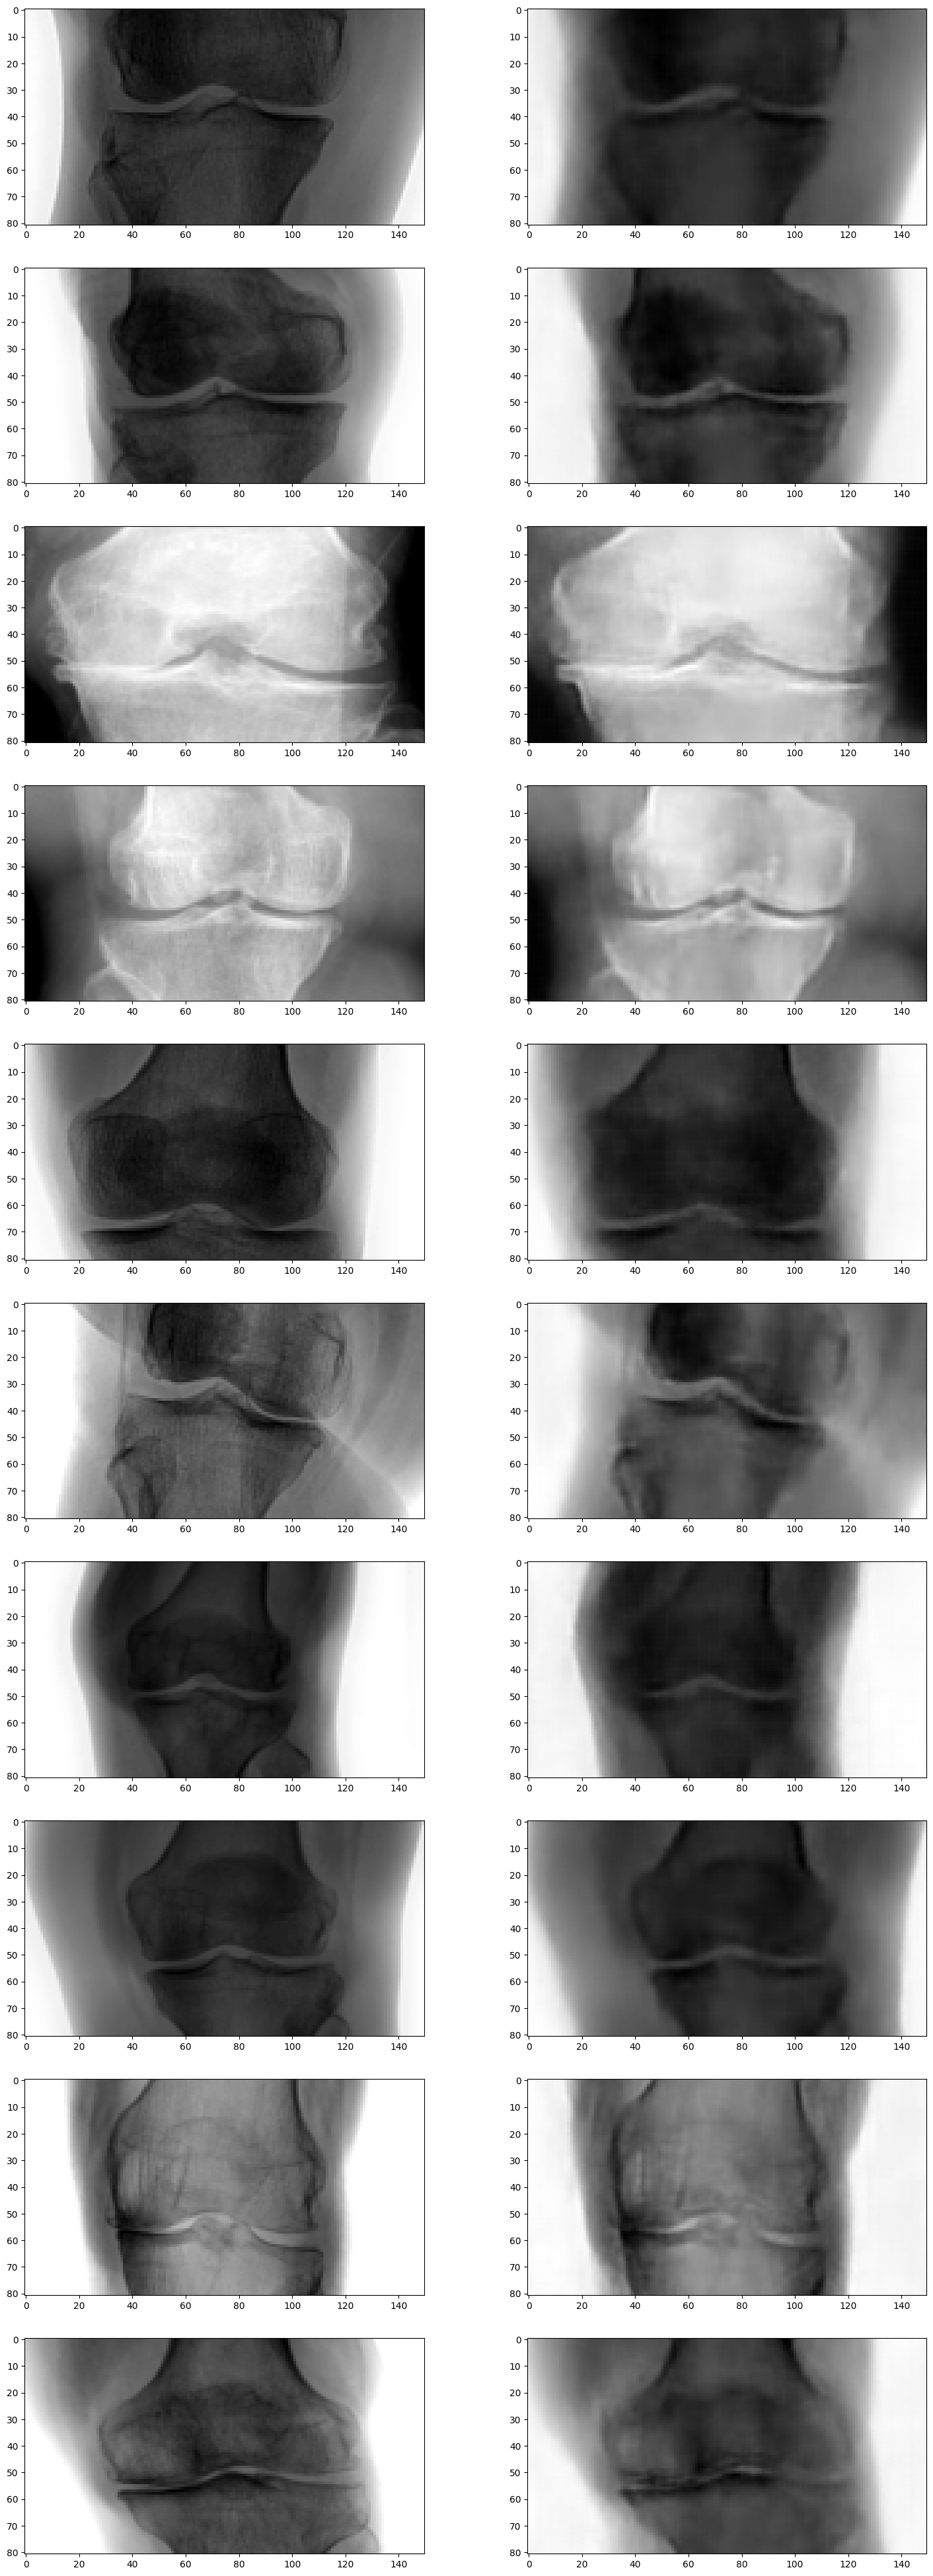

In [52]:
import math
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 50))
plt.gray()
imgs = outputs[0][0].detach().numpy()[:10]
recon = outputs[0][1].detach().numpy()[:10]
# plt.imshow(imgs)
# plt.imshow(recon)
for i, item in enumerate(imgs):
    # print(item)
    plt.subplot(len(imgs), 2, i * 2 +1)
    # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
    # item: 1, 28, 28
    plt.imshow(item[0])

for i, item in enumerate(recon):
    plt.subplot(len(imgs), 2, i*2+2) # row_length + i + 1
    # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
    # item: 1, 28, 28
    plt.imshow(item[0])

Как видим, модель достаточно точно может восстановить изображение из дескриптора размерности 2048

Сохраняем модель в S3

In [129]:
torch.save(model.state_dict(), 'autoencoder.bin')

In [130]:
s3_client.upload_file('autoencoder.bin', BUCKET_NAME, 'models/autoencoder.bin')

In [4]:
# s3_client.download_file(BUCKET_NAME, 'models/autoencoder.bin', 'autoencoder.bin')
model = TorchConvAutoEncoder()
model.load_state_dict(torch.load('autoencoder.bin'))

<All keys matched successfully>

Считаем дескрипторы для изображений

In [7]:
from tqdm.notebook import tqdm


def loader(path):
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if image.dtype == np.uint16:
        image = (image / 256)
    img = Image.fromarray(image.astype("uint8"))
    return img


SINGLE_PATH = Path('.') / 'single'
train_transforms = transforms.Compose([
    transforms.v2.Grayscale(num_output_channels=1),
    transforms.v2.Resize((81, 150)),
    v2.ToImage(),
    transforms.v2.ConvertImageDtype(),
    transforms.v2.Normalize((0.5,), (0.5,))
])
dataset = ImageFolder(SINGLE_PATH, transform=train_transforms, loader=loader)
dataset_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    num_workers=1, 
    persistent_workers=True,
)
descriptors = []
for batch, labels in tqdm(dataset_loader):
    batch_desc = model.encoder(batch)
    for desc, label in zip(batch_desc, labels):
        descriptors.append((desc.detach().numpy(), label))
    

  0%|          | 0/92 [00:00<?, ?it/s]

In [8]:
len(descriptors)

1465

In [9]:
X_data = pd.DataFrame(d[0] for d in descriptors)
y_data = pd.DataFrame(d[1].detach().numpy() for d in descriptors)

In [10]:
desc_df = X_data.copy()
desc_df['target'] = y_data
desc_df.to_csv('autoenc_desc.csv', index=False)

In [11]:
desc_df = pd.read_csv('autoenc_desc.csv')
y_data = desc_df['target']
X_data = desc_df.drop(columns='target')

In [17]:
X_data.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
1348,-8.372392,0.781178,-6.713779,-3.664166,0.909698,-1.857212,-6.627858,-5.861728,-2.753762,-7.733458,...,8.849648,-5.590591,-11.709795,-3.528854,5.891355,-8.007689,5.872162,-1.820132,-2.707579,-4.279290
459,-6.140529,-3.548248,-0.048899,-4.628163,-4.639240,-0.730991,4.647335,-8.623238,0.177840,-11.028341,...,4.615953,-9.386421,-10.763023,-5.085660,3.441696,-1.916832,4.769412,-5.570227,5.692129,-6.744516
368,2.785550,0.302742,-7.598081,-7.629572,2.202328,7.935215,4.332890,-3.333291,-2.634497,-10.476492,...,0.781597,-5.732143,-3.915036,-4.193051,0.509029,-3.664687,-1.137380,-4.867397,3.978484,-2.343324
22,-10.146183,-4.555542,0.620866,-7.123474,1.085916,-2.934112,-2.436707,-3.155321,-1.649084,-6.748964,...,1.403760,-4.730819,-1.396187,0.937264,3.898015,-3.320289,1.975953,-7.431702,4.839334,0.201039
52,-0.050286,-5.295170,-0.778973,-8.474730,-5.287198,-5.819921,-1.126702,0.109740,1.269954,2.658259,...,-10.878983,7.366323,18.950611,-0.452935,-2.940464,-0.798286,3.400490,-7.881323,6.764285,1.251526
864,10.018779,-1.764310,3.645030,-12.035694,-6.336053,3.345296,13.286209,-4.672428,7.134692,-13.758711,...,-15.091137,-4.016795,2.455944,-9.301470,-6.492101,4.110240,2.130121,-16.389620,22.232246,-4.767550
169,-13.968946,-6.169083,2.739262,-8.406779,-9.699429,-6.603136,-4.269726,-10.864811,1.092170,-0.165431,...,-10.233839,3.668731,16.377813,0.968437,-1.995499,1.703045,5.305942,-19.163198,17.231426,0.965669
632,-12.549810,0.132052,4.303404,-9.800018,4.593549,-11.212995,-6.407520,-4.511989,10.034768,13.097752,...,-4.919528,-1.084884,6.434732,-7.300990,6.869196,-0.426034,4.020567,-8.128626,16.568426,10.166822
1258,-1.630625,-8.821001,-1.517983,-9.287471,-9.087989,-0.796989,0.456002,-5.904797,-3.171838,-6.752531,...,-10.458630,-0.109655,9.575340,2.311213,-8.033009,4.410447,3.010114,-15.330112,16.226082,-3.262073
35,6.613350,-0.239562,4.083996,-4.779512,0.159740,8.638157,0.219044,3.834667,11.200365,-5.774983,...,-5.146594,-1.321048,-14.566610,-1.933349,-4.896015,6.485204,-4.013720,-7.107242,10.428497,2.229299


In [16]:
y_data.sample(10)

1352    4
985     2
906     2
1464    4
1106    3
1376    4
909     2
392     0
1110    3
368     0
Name: target, dtype: int64

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, stratify=y_data)

In [20]:
import numpy as np
import catboost as cb
from catboost.utils import eval_metric

val_pool = cb.Pool(X_test, y_test)
train_pool = cb.Pool(X_train, y_train)

In [23]:
cb_model = cb.CatBoostClassifier(
    loss_function='MultiClass',
    n_estimators=2000,
    learning_rate=0.05,
    bootstrap_type='Bernoulli',
    subsample=0.3,
    rsm=0.3,
    boosting_type='Plain',
    task_type="CPU",
    depth=5,
    eval_metric='AUC',
)
cb_model.fit(train_pool, verbose=0, eval_set=val_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [24]:
from sklearn.metrics import roc_auc_score, f1_score

y_pred_proba = cb_model.predict_proba(X_test)
y_pred = cb_model.predict(X_test)
print('roc_auc:', roc_auc_score(y_test, y_pred_proba, multi_class='ovo'))
print('f1:', f1_score(y_test, y_pred, average='macro'))

roc_auc: 0.8373335287582362
f1: 0.5413216419776232


Модель catboost на основе дескрипторов автоэнкодера предсказывает хуже, чем на основе HOG.

Сохраняем модель

In [25]:
cb_model.save_model('autoencoder_catboost.cbm', format="cbm")
s3_client.upload_file('autoencoder_catboost.cbm', BUCKET_NAME, 'models/autoencoder_catboost.cbm')